# Finding dublicates in beer database 


In [47]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import fuzzy
import matplotlib.pyplot as plt
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance
from rapidfuzz.distance import JaroWinkler, DamerauLevenshtein


import os.path
path = "beer_profile_and_ratings.csv"

df = pd.read_csv(path)
df.head()


,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [49]:
# Ініціалізація Soundex
soundex = fuzzy.Soundex(4)

import unicodedata
import re

def soundex_python(word):
    word = clean_ascii_safe(word).upper()
    if not word:
        return ""

    replacements = {
        'BFPV': '1',
        'CGJKQSXZ': '2',
        'DT': '3',
        'L': '4',
        'MN': '5',
        'R': '6'
    }

    soundex = word[0]

    for char in word[1:]:
        for key in replacements:
            if char in key:
                code = replacements[key]
                if code != soundex[-1]:
                    soundex += code
                break
        else:
            if soundex[-1] != '0':
                soundex += '0'

    soundex = soundex.replace('0', '')
    return (soundex + '000')[:4]

def soundex_similarity(str1, str2):
    s1 = soundex_python(str1)
    s2 = soundex_python(str2)
    return int(s1 == s2) * 100



def clean_ascii_safe(text):
    # Перетворюємо все у байти, потім назад у строку з ігноруванням помилок
    try:
        text = str(text)
    except:
        return ''
    text_bytes = text.encode('utf-8', errors='ignore')
    text = text_bytes.decode('ascii', errors='ignore')

    # Нормалізуємо символи (é → e)
    text = unicodedata.normalize('NFKD', text)

    # Прибираємо зайві символи, залишаємо тільки ASCII
    text = re.sub(r"[^A-Za-z0-9\s&\-/'().]", '', text)

    return text.strip()







# Функція для Damerau-Levenshtein
def damerau_levenshtein_distance(str1, str2):
    return DamerauLevenshtein.distance(str(str1), str(str2))

# Функція для обчислення ймовірності належності
def calculate_similarity2(name_jw, name_soundex, brew_jw, brew_soundex, style_jw, style_soundex):
    return round((name_jw * 0.4 + name_soundex * 0.1 +
                  brew_jw * 0.2 + brew_soundex * 0.1 +
                  style_jw * 0.15 + style_soundex * 0.05), 2)

# Функція для обчислення ймовірності належності
def calculate_similarity(name_jw, name_soundex, brew_jw, brew_soundex, style_jw, style_soundex, name_dl, brew_dl, style_dl):
    return round((name_jw * 0.3 + name_soundex * 0.1 +
                  brew_jw * 0.2 + brew_soundex * 0.1 +
                  style_jw * 0.15 + style_soundex * 0.05 +
                  name_dl * 0.05 + brew_dl * 0.05 + style_dl * 0.05), 2)


In [61]:
def create_comparison_table(df, threshold=90):
    results = []

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            # Назви пива
            name1 = str(df.loc[i, 'Beer Name (Full)'])
            name2 = str(df.loc[j, 'Beer Name (Full)'])

            # Порівняння за допомогою JaroWinkler
            name_jw = JaroWinkler.normalized_similarity(name1, name2)
            name_soundex = soundex_similarity(name1, name2) / 100
            name_dl = damerau_levenshtein_distance(name1, name2) / max(len(name1), len(name2))  # Додаємо Damerau-Levenshtein

            # Броварня (Brewery)
            brew1 = str(df.loc[i, 'Brewery'])
            brew2 = str(df.loc[j, 'Brewery'])

            brew_jw = JaroWinkler.normalized_similarity(brew1, brew2)
            brew_soundex = soundex_similarity(brew1, brew2) / 100
            brew_dl = damerau_levenshtein_distance(brew1, brew2) / max(len(brew1), len(brew2))  # Додаємо Damerau-Levenshtein

            # Стиль пива (Style)
            style1 = str(df.loc[i, 'Style'])
            style2 = str(df.loc[j, 'Style'])

            style_jw = JaroWinkler.normalized_similarity(style1, style2)
            style_soundex = soundex_similarity(style1, style2) / 100
            style_dl = damerau_levenshtein_distance(style1, style2) / max(len(style1), len(style2))  # Додаємо Damerau-Levenshtein

            # Розрахунок ймовірності
            probability = calculate_similarity(name_jw, name_soundex, brew_jw, brew_soundex, style_jw, style_soundex, name_dl, brew_dl, style_dl)
            decision = "Належить" if probability * 100 >= threshold else "Не належить"

            results.append({
                "ID 1": i,
                "ID 2": j,
                "Назва 1": name1,
                "Назва 2": name2,
                "Броварня 1": brew1,
                "Броварня 2": brew2,
                "Стиль 1": style1,
                "Стиль 2": style2,
                
                "Name JW": round(name_jw, 2),
                "Name Soundex": round(name_soundex, 2),
                "Name Damerau-Levenshtein": round(name_dl, 2),
                
                "Brewery JW": round(brew_jw, 2),
                "Brewery Soundex": round(brew_soundex, 2),
                "Brewery Damerau-Levenshtein": round(brew_dl, 2),

                "Style JW": round(style_jw, 2),
                "Style Soundex": round(style_soundex, 2),
                "Style Damerau-Levenshtein": round(style_dl, 2),
                
                "Ймовірність": f"{int(probability * 100)}%",
                "Рішення": decision
            })

    result_df = pd.DataFrame(results)

    # 🔝 Топ найсхожіших
    result_df["Ймовірність (%)"] = result_df["Ймовірність"].str.replace('%', '').astype(int)
    top_matches = result_df.sort_values(by="Ймовірність (%)", ascending=False).head(10)

    print("\n🔝 Топ 10 найсхожіших записів:")
    display(top_matches.drop(columns=["Ймовірність (%)"]))

Implementation of fuzzy logic to decide if the beers are the same.



🔝 Топ 10 найсхожіших записів:


,ID 1,ID 2,Назва 1,Назва 2,Броварня 1,Броварня 2,Стиль 1,Стиль 2,Name JW,Name Soundex,Name Damerau-Levenshtein,Brewery JW,Brewery Soundex,Brewery Damerau-Levenshtein,Style JW,Style Soundex,Style Damerau-Levenshtein,Ймовірність,Рішення
145,3,5,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Altbier,Altbier,0.97,1.0,0.10,1.00,1.0,0.00,1.0,1.0,0.00,90%,Належить
239,5,10,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Altbier,Altbier,0.95,1.0,0.21,1.00,1.0,0.00,1.0,1.0,0.00,90%,Належить
150,3,10,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Altbier,Altbier,0.95,1.0,0.18,1.00,1.0,0.00,1.0,1.0,0.00,89%,Належить
49,1,2,Long Trail Brewing Co. Double Bag,Long Trail Brewing Co. Long Trail Ale,Long Trail Brewing Co.,Long Trail Brewing Co.,Altbier,Altbier,0.92,1.0,0.32,1.00,1.0,0.00,1.0,1.0,0.00,89%,Належить
622,14,42,Victory Brewing Company Ten Years Alt,Victory Brewing Company Old Horizontal,Victory Brewing Company,Victory Brewing Company,Altbier,Barleywine - American,0.91,1.0,0.32,1.00,1.0,0.00,0.5,0.0,0.81,80%,Не належить
558,12,49,Free State Brewing Co. Ad Astra Ale,Firestone Walker Brewing Co. Helldorado,Free State Brewing Co.,Firestone Walker Brewing Co.,Altbier,Barleywine - American,0.66,1.0,0.51,0.80,1.0,0.36,0.5,0.0,0.81,72%,Не належить
44,0,45,Alaskan Brewing Co. Alaskan Amber,AleSmith Brewing Company AleSmith Old Numbskull,Alaskan Brewing Co.,AleSmith Brewing Company,Altbier,Barleywine - American,0.63,1.0,0.60,0.65,1.0,0.46,0.5,0.0,0.81,69%,Не належить
637,15,23,Mother's Brewing Company Three Blind Mice,Mission Brewery Mission Amber,Mother's Brewing Company,Mission Brewery,Altbier,Altbier,0.64,0.0,0.76,0.75,0.0,0.71,1.0,1.0,0.00,62%,Не належить
773,19,33,August Schell Brewing Company Barrel Aged Schm...,Rush River Brewing Company Über Alt,August Schell Brewing Company,Rush River Brewing Company,Altbier,Altbier,0.72,0.0,0.54,0.78,0.0,0.31,1.0,1.0,0.00,62%,Не належить
595,14,15,Victory Brewing Company Ten Years Alt,Mother's Brewing Company Three Blind Mice,Victory Brewing Company,Mother's Brewing Company,Altbier,Altbier,0.72,0.0,0.46,0.82,0.0,0.29,1.0,1.0,0.00,62%,Не належить


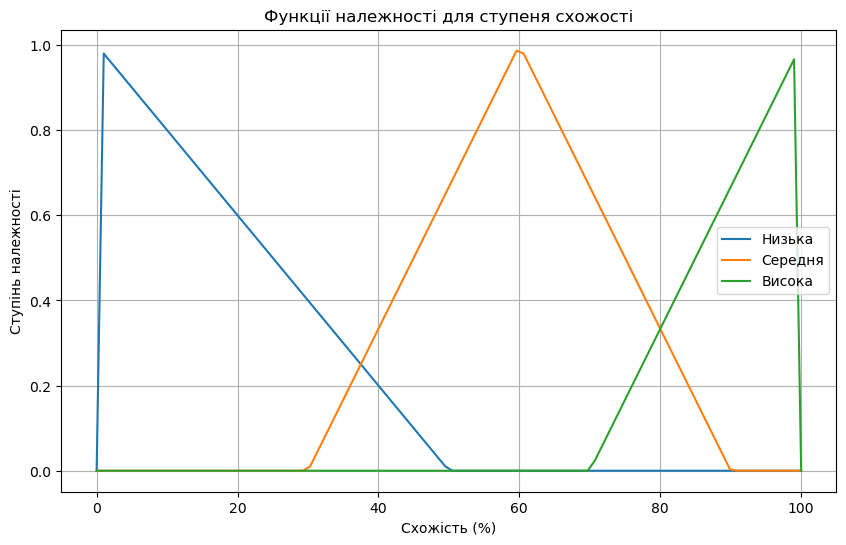

In [65]:


# 🧮 Виклик функції
create_comparison_table(df.head(50), threshold=85)  # обмеження для швидкості

# 📊 Візуалізація функції належності
x = np.linspace(0, 100, 100)

def trimf(x, params):
    a, b, c = params
    return np.maximum(np.minimum((x - a) / (b - a + 1e-6), (c - x) / (c - b + 1e-6)), 0)

low = trimf(x, [0, 0, 50])
medium = trimf(x, [30, 60, 90])
high = trimf(x, [70, 100, 100])

plt.figure(figsize=(10, 6))
plt.plot(x, low, label='Низька')
plt.plot(x, medium, label='Середня')
plt.plot(x, high, label='Висока')
plt.title('Функції належності для ступеня схожості')
plt.xlabel('Схожість (%)')
plt.ylabel('Ступінь належності')
plt.legend()
plt.grid(True)
plt.show()
